![](https://assets.website-files.com/60e7f71b22c6d0b9cf329ceb/621e1a2f28ded71ee95aeede_6ProvenSalesForecastingMethodstoDriveRevenue1_a117440b5ae227c3dba5264a6521da06_2000.png)

# Introdução

O objetivo deste projeto é desenvolver um modelo de forecasting para prever a demanda dos próximos 5 dias do item da empresa **Frexco**, baseado em uma série temporal. Para essa previsão será utilizado o modelo ARIMA.

# Data Cleaning

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('Dados.xlsx', index_col=0)

In [3]:
df = df.reset_index(level=0)

In [4]:
df.head()

,Data,Vendas
0,2022-12-06,870
1,2022-12-07,868
2,2022-12-08,1189
3,2022-12-09,742
4,2022-12-10,317


In [5]:
df['Data'] = df['Data'].astype(str)

In [6]:
df[['Ano', 'Mes', 'Dia']] = df['Data'].str.split('-', expand=True).astype(int)
df.head()

,Data,Vendas,Ano,Mes,Dia
0,2022-12-06,870,2022,12,6
1,2022-12-07,868,2022,12,7
2,2022-12-08,1189,2022,12,8
3,2022-12-09,742,2022,12,9
4,2022-12-10,317,2022,12,10


# Análise Exploratória de Dados (EDA)

In [7]:
import seaborn as sns
import plotly.express as px

In [8]:
import plotly.io as pio
pio.renderers.default = "svg"

In [9]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


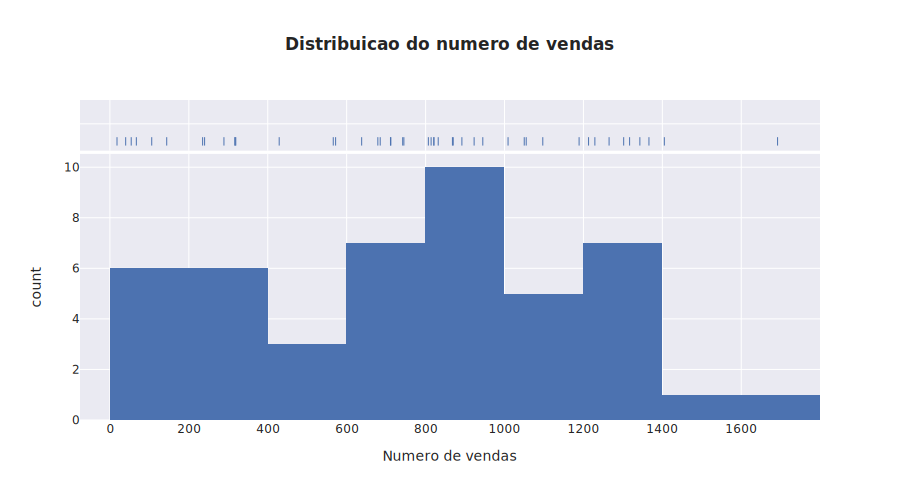

In [10]:
px.histogram(df,x='Vendas', width=900, marginal='rug',template='seaborn',labels={'Vendas':'Numero de vendas'},title="<b> Distribuicao do numero de vendas")

A maior frequência de número de vendas está no intervalo de 800 a 1000 vendas.

In [11]:
vendas = np.array(df['Vendas'])

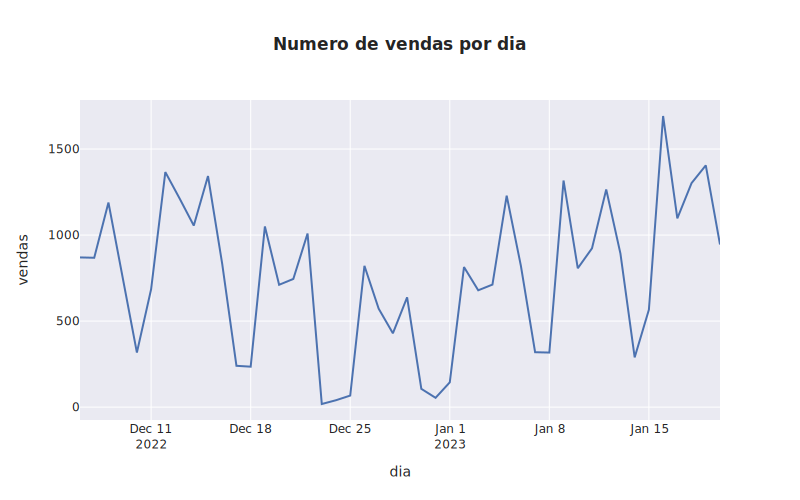

In [12]:
fig = px.line(df, x="Data", y="Vendas", width=800, labels={'Data':'dia','Vendas':'vendas'}, template="seaborn",title="<b> Numero de vendas por dia")
fig.show()

In [13]:
z = df.sort_values('Vendas', ascending=False).reset_index(drop=True)

In [14]:
z = z[['Data', 'Vendas']]

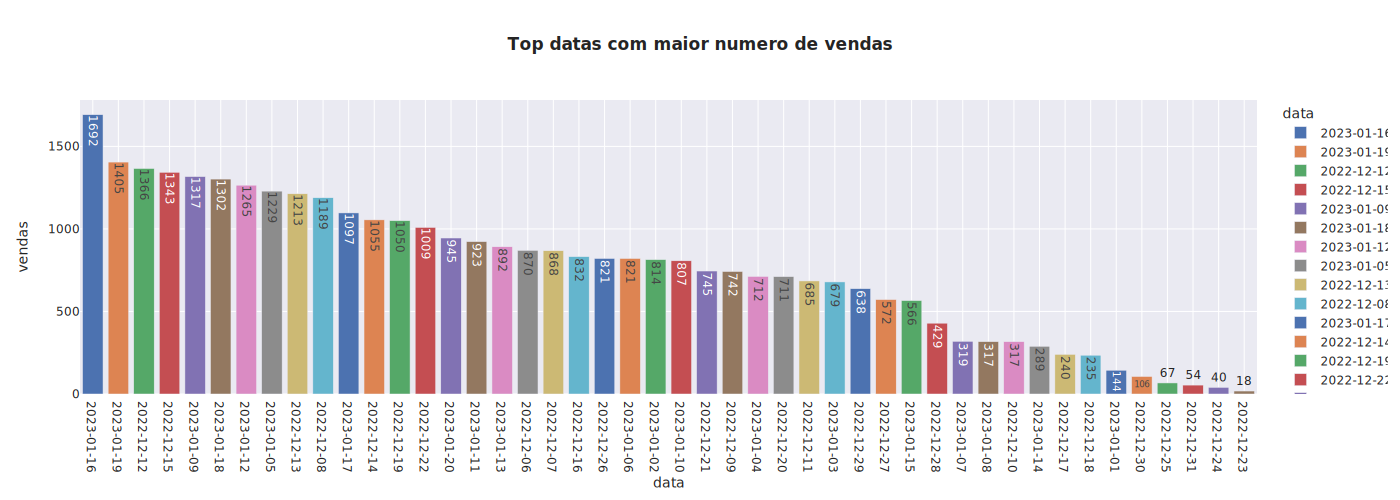

In [15]:
fig=px.bar(z,x='Data',y='Vendas',color='Data', width=1400,
           labels={'Data':'data','Vendas':'vendas'},text='Vendas',template='seaborn',title="<b> Top datas com maior numero de vendas")

fig.update_layout(
xaxis_type = 'category'
)

fig.show()

In [16]:
z = df[df['Dia'] <= 20]
z = df.groupby('Mes', as_index=False)[['Vendas']].sum().sort_values(by='Vendas',ascending=False)
z = z.replace(1, 'Janeiro de 2023')
z = z.replace(12, 'Dezembro de 2022')

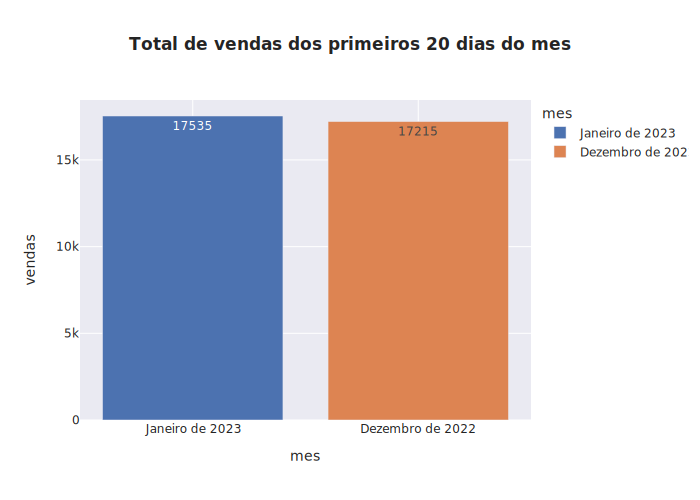

In [17]:
fig=px.bar(z,x='Mes',y='Vendas',color='Mes',
           labels={'Mes':'mes','Vendas':'vendas'},text='Vendas',template='seaborn',title="<b> Total de vendas dos primeiros 20 dias do mes")

fig.show()

# Machine Learning

## Data Visualization

In [18]:
data = pd.DataFrame(df['Vendas'])

In [19]:
data.head()

,Vendas
0,870
1,868
2,1189
3,742
4,317


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Vendas  46 non-null     int64
dtypes: int64(1)
memory usage: 496.0 bytes


In [21]:
# descrição da coluna de vendas
data.describe()['Vendas']

count      46.000000
mean      755.434783
std       430.762201
min        18.000000
25%       346.500000
50%       810.500000
75%      1053.750000
max      1692.000000
Name: Vendas, dtype: float64

In [22]:
# checando nulos
data.isnull().sum()

Vendas    0
dtype: int64

### Reescalando os dados

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
scaler = StandardScaler()

scaler.fit(pd.DataFrame(data['Vendas']))

data['Vendas'] = scaler.transform(pd.DataFrame(data['Vendas']))

In [25]:
data.head()

,Vendas
0,0.268898
1,0.264204
2,1.017629
3,-0.031533
4,-1.029059


## Build Model

### Seleção de hiperparâmetros

#### Checando se os dados são estacionários pelo teste ADF

In [26]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
from pmdarima.arima import ADFTest 

In [28]:
adf = ADFTest(alpha = 0.05)
adf.should_diff(data["Vendas"])

(0.32861105775592403, True)

Como o p-value foi maior que 0.05, isso significa que a série temporal **não é estacionária**.

#### Transformando a time series em estacionária

In [29]:
# aumentando a ordem de diferenciação

data["diff_1"] = data["Vendas"].diff(periods=1)
data["diff_2"] = data["Vendas"].diff(periods=2)
data["diff_3"] = data["Vendas"].diff(periods=3)

In [30]:
adf = ADFTest(alpha = 0.05)
print(f'p-value diff 1: {adf.should_diff(data["diff_1"].dropna())}')
print(f'p-value diff 2: {adf.should_diff(data["diff_2"].dropna())}')
print(f'p-value diff 3: {adf.should_diff(data["diff_3"].dropna())}')

p-value diff 1: (0.01, False)
p-value diff 2: (0.01, False)
p-value diff 3: (0.01, False)


Os dados agora **são estacionários**, e somente 1 grau de diferenciação (**d=1**) foi necessário.

In [31]:
from statsmodels.graphics.tsaplots import plot_acf

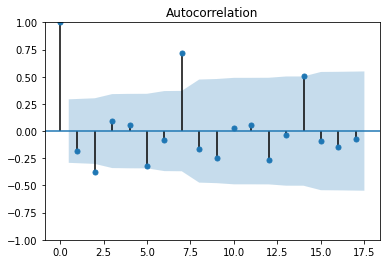

In [32]:
plot_acf(data['diff_1'].dropna());

Foi descoberto durante a avaliação do modelo que aumentar a ordem de autoregressão **'p'** até próximo de **50** melhorou significamente o desempenho do modelo. O **'q'** será o número de lags que cruzam o threshold, que no caso são **3**.

Os parâmetros do modelo ARIMA serão então: **p=50; d=1; q=3**

## Fit

In [33]:
from statsmodels.tsa.arima.model import ARIMA

In [34]:
# build model
model = ARIMA(data.Vendas, order=(50, 1, 3))

In [35]:
model = model.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Vendas   No. Observations:                   46
Model:                ARIMA(60, 1, 3)   Log Likelihood                  -4.582
Date:                Sat, 04 Feb 2023   AIC                            137.165
Time:                        11:53:07   BIC                            252.791
Sample:                             0   HQIC                           180.269
                                 - 46                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0089     58.632      0.000      1.000    -114.907     114.925
ar.L2          0.1448     62.879      0.002      0.998    -123.097     123.386
ar.L3         -0.0829     75.728     -0.001      0.999    -148.507     148.341
ar.L4         -0.0740    121.592     -0.001      1.000    -238.390     238.242
ar.L5          0.1866     23.786      0.008      0.994     -46.434      46.807
ar.L6         -0.6624     69.658     -0.010      0.992    -137.190     135.865
ar.L7          0.1752     22.008      0.008      0.994     -42.960      43.310
ar.L8          0.0397     18.315      0.002      0.998     -35.858      35.937
ar.L9         -0.5266     22.360     -0.024      0.981     -44.352      43.299
ar.L10         0.2458     24.535      0.010      0.992     -47.843      48.334
ar.L11         0.3257     31.474      0.010      0.992     -61.362      62.013
ar.L12        -0.1320      4.933     -0.027      0.979      -9.800       9.536
ar.L13        -0.2030     29.835     -0.007      0.995     -58.679      58.273
ar.L14         0.5829     13.355      0.044      0.965     -25.592      26.758
ar.L15        -0.2351     29.202     -0.008      0.994     -57.469      56.999
ar.L16        -0.0074     39.460     -0.000      1.000     -77.347      77.332
ar.L17        -0.1396     49.939     -0.003      0.998     -98.019      97.740
ar.L18         0.1553     39.206      0.004      0.997     -76.687      76.998
ar.L19        -0.1788     22.662     -0.008      0.994     -44.595      44.237
ar.L20         0.0976     41.850      0.002      0.998     -81.926      82.121
ar.L21        -0.1201     25.209     -0.005      0.996     -49.530      49.290
ar.L22        -0.0621     20.514     -0.003      0.998     -40.268      40.144
ar.L23        -0.0418     34.000     -0.001      0.999     -66.680      66.597
ar.L24        -0.0777     42.046     -0.002      0.999     -82.487      82.331
ar.L25        -0.0112     32.232     -0.000      1.000     -63.184      63.162
ar.L26        -0.4872     26.454     -0.018      0.985     -52.336      51.362
ar.L27         0.4370      7.981      0.055      0.956     -15.206      16.080
ar.L28         0.2512     50.901      0.005      0.996     -99.513     100.015
ar.L29        -0.1535     29.315     -0.005      0.996     -57.610      57.303
ar.L30         0.1095     76.794      0.001      0.999    -150.403     150.622
ar.L31         0.4499     33.133      0.014      0.989     -64.490      65.390
ar.L32        -0.6885     20.522     -0.034      0.973     -40.911      39.534
ar.L33         0.1908     42.666      0.004      0.996     -83.433      83.815
ar.L34         0.5507     43.645      0.013      0.990     -84.992      86.093
ar.L35         0.0995      5.598      0.018      0.986     -10.872      11.071
ar.L36         0.2414     64.052      0.004      0.997    -125.298     125.780
ar.L37         0.2070     46.117      0.004      0.996     -90.180      90.594
ar.L38        -0.2942     49.066     -0.006      0.995     -96.461      95.872
ar

## Evaluate

In [37]:
import matplotlib.pyplot as plt

In [38]:
from statsmodels.graphics.tsaplots import plot_predict

In [39]:
data_pred = model.predict(dynamic=False)

In [40]:
from sklearn.metrics import mean_squared_error

In [41]:
mean_squared_error(data.Vendas, data_pred)

0.16504904803521395

# Resultados

O **MSR** do modelo foi de aproximadamente **0.16**

## Gráfico Real vs Previsto do modelo ARIMA

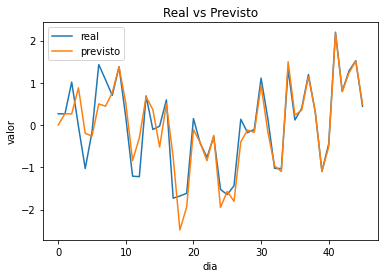

In [42]:
plt.plot(data.Vendas, linestyle = '-', label = 'real')
plt.plot(data_pred, linestyle = '-', label = 'previsto')

plt.xlabel("dia")
plt.ylabel("valor")

plt.title("Real vs Previsto")
plt.legend(loc='best')

plt.show()

## Previsão de vendas dos próximos 5 dias

In [43]:
forecast_next_5_days = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(model.forecast(5))), index = pd.date_range(start='21/1/2023', periods=5)).rename(columns={'index':'Data'})

forecast_next_5_days.columns = ['Vendas']

forecast_next_5_days['Vendas'] = forecast_next_5_days['Vendas'].astype(int)

In [44]:
forecast_next_5_days

,Vendas
2023-01-21,336
2023-01-22,-117
2023-01-23,1095
2023-01-24,763
2023-01-25,412


*Muito obrigado por vir até o fim :)*